In [14]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [15]:
data=pd.read_excel('../../product_performance_blstm\dataset_new.xlsx',sheet_name='train')
data

,KodeBarang,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,cluster
0,04121,7,9,6,9,40,0,3,0,7,...,67,77,11,57,43,50,37,21,136,0
1,18031,230,227,279,153,190,256,267,305,238,...,336,153,103,221,360,280,240,120,548,1
2,04161,102,50,45,41,71,11,52,14,66,...,21,20,7,33,21,28,30,10,18,0
3,04162,272,155,214,226,268,110,204,253,193,...,102,118,120,211,292,105,108,101,117,1
4,04163,28,28,29,52,44,21,47,15,24,...,18,23,22,16,22,31,36,17,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,04157,55,64,44,61,30,1,24,37,67,...,20,10,300,34,7,7,6,4,21,0
102,18104,46,295,83,112,70,40,18,140,97,...,47,54,27,15,57,132,66,34,146,0
103,18106,200,204,0,2,10,7,0,27,74,...,15,136,15,15,14,131,84,12,14,0
104,18092,297,418,329,70,498,59,298,376,259,...,450,498,254,260,336,493,438,408,322,1


In [16]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [17]:
len(data['cluster'].unique())

4

In [18]:
#now lets take clusters
c0 = data.query("cluster == 0")
print("Jumlah Produk:")
print(c0['KodeBarang'].size)
c1 = data.query("cluster == 1")
print("Jumlah Produk:")
print(c1['KodeBarang'].size)
c2 = data.query("cluster == 2")
print("Jumlah Produk:")
print(c2['KodeBarang'].size)
c3 = data.query("cluster == 3")
print("Jumlah Produk:")
print(c3['KodeBarang'].size)

Jumlah Produk:
70
Jumlah Produk:
31
Jumlah Produk:
4
Jumlah Produk:
1


In [19]:
#oke ada ternyata yang cuman sendirian (1 product di cluster tersebut), kita beresin dia dulu, the easiest, dan biar keliatan kita
#ngapain aja di time series ini
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
# ini fungsinya buat nge ubah dataset jadi windowed

In [20]:
col = c0.KodeBarang.values

In [21]:
#next kita ubah bentuk data nya dari yang tadinya kesamping jadi ke bawah, tapi pertama mau aku drop dulu cluster sama kode produknya
c0=c0.drop(columns=['KodeBarang','cluster'])
c0

,1,2,3,4,5,6,7,8,9,10,...,45,46,47,48,49,50,51,52,53,54
0,7,9,6,9,40,0,3,0,7,2,...,62,67,77,11,57,43,50,37,21,136
2,102,50,45,41,71,11,52,14,66,76,...,23,21,20,7,33,21,28,30,10,18
4,28,28,29,52,44,21,47,15,24,32,...,18,18,23,22,16,22,31,36,17,14
6,40,11,40,50,43,0,1,31,0,6,...,2,11,0,2,0,0,4,0,0,0
8,85,164,231,157,195,122,196,136,215,232,...,32,71,53,42,113,57,45,34,78,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,0,0,0,10,15,63,228,223,177,365,...,0,0,0,5,-5,15,0,0,0,0
100,260,47,289,189,73,2,360,-13,339,508,...,101,21,33,13,31,17,46,82,22,29
101,55,64,44,61,30,1,24,37,67,85,...,21,20,10,300,34,7,7,6,4,21
102,46,295,83,112,70,40,18,140,97,136,...,55,47,54,27,15,57,132,66,34,146


<AxesSubplot:>

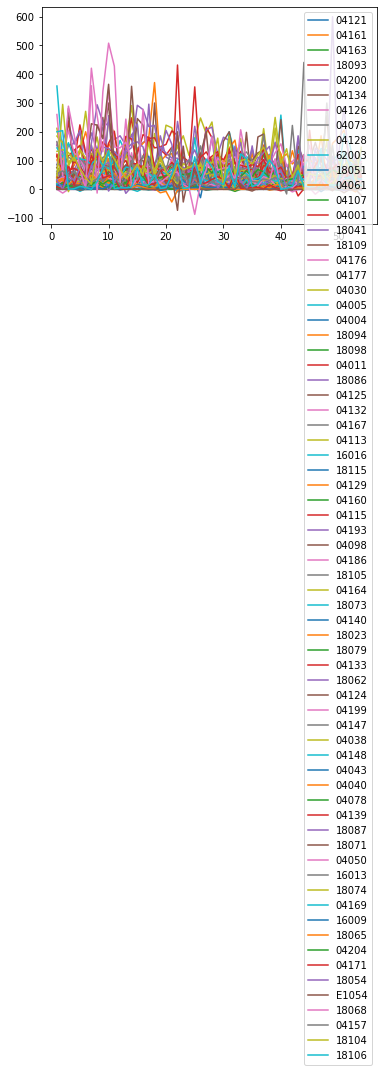

In [22]:
c0.set_index(col,inplace=True)
c0.T.plot()

In [23]:
#Ambil satu sample dari cluster 0
c0 = c0.sample()

<AxesSubplot:>

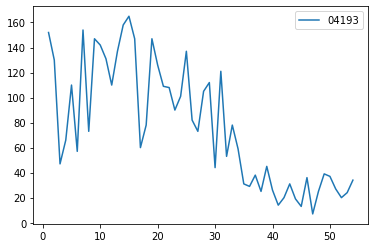

In [24]:
c0.T.plot()

In [25]:
#next, buat dia kayak mejeneng time series seperti biasanya, which is datanya ke bawah, tapi di average per tanggal 
new_c0=[]
time=[]

for idx,a in enumerate(c0):
    new_c0.append(c0[a].mean())
    time.append(idx)


<AxesSubplot:>

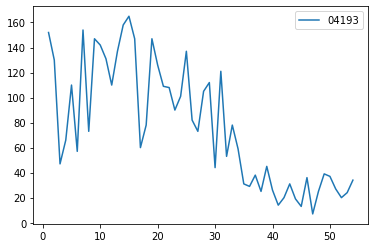

In [26]:
c0.T.plot()

In [27]:
#normalisasi, karena gap nya ada yang sampe ribuan, biar lebih gampang tugas ann nya
series=new_c0
min = np.min(series)
max = np.max(series)
series = series - min
series = series / (max-min)
time = np.array(time)

In [28]:
series

array([0.91772152, 0.77848101, 0.25316456, 0.37341772, 0.65189873,
       0.3164557 , 0.93037975, 0.41772152, 0.88607595, 0.85443038,
       0.78481013, 0.65189873, 0.82278481, 0.9556962 , 1.        ,
       0.88607595, 0.33544304, 0.44936709, 0.88607595, 0.75316456,
       0.64556962, 0.63924051, 0.52531646, 0.59493671, 0.82278481,
       0.47468354, 0.41772152, 0.62025316, 0.66455696, 0.23417722,
       0.72151899, 0.29113924, 0.44936709, 0.32911392, 0.15189873,
       0.13924051, 0.19620253, 0.11392405, 0.24050633, 0.12025316,
       0.0443038 , 0.08227848, 0.15189873, 0.07594937, 0.03797468,
       0.1835443 , 0.        , 0.11392405, 0.20253165, 0.18987342,
       0.12658228, 0.08227848, 0.10759494, 0.17088608])

In [29]:
split_time = 3 # ini berapa bulan terkahir yang mau di potong buat pengujian?

time_train = time[:-split_time]
x_train =  series[:-split_time]
time_valid =  time[-split_time:]
x_valid =  series[-split_time:]

In [30]:
x_valid

array([0.08227848, 0.10759494, 0.17088608])

In [31]:
#buat data biar dibagi per window, jadi me masang masangkan waktu dan value,
window_size = 2
batch_size = 2
shuffle_buffer_size = 10

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

In [32]:
train_set

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>

In [33]:
valid_set

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>

In [34]:
from keras.callbacks import  EarlyStopping
callbacks = EarlyStopping(
    min_delta=0.0001,
    
    patience=7,
    restore_best_weights=True,
)

In [35]:
model = tf.keras.Sequential([
        tf.keras.layers.Dense(2, input_shape=[None, 1]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(l1=0.01)),
        tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='relu')
    ])

    #the blstm part

In [36]:
#Using mae and mse
#model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),metrics=['mae'],loss='mse')
model.compile(optimizer=tf.keras.optimizers.Adam(),metrics=['mae'],loss='mse')
model.summary()
hist=model.fit(train_set,epochs=150,validation_data=valid_set, batch_size=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, None, 2)           4         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         34304     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              66560     
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               5

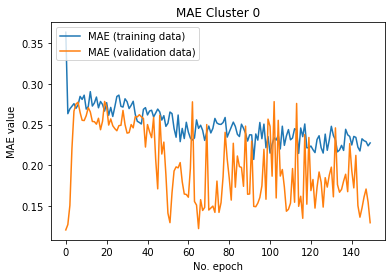

In [37]:
import matplotlib.pyplot as plt
plt.plot(hist.history['mae'], label='MAE (training data)')
plt.plot(hist.history['val_mae'], label='MAE (validation data)')

plt.title("MAE Cluster 0")
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

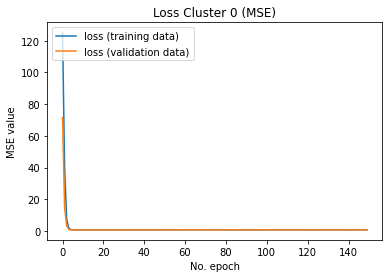

In [38]:
plt.plot(hist.history['loss'], label='loss (training data)')
plt.plot(hist.history['val_loss'], label='loss (validation data)')

plt.title("Loss Cluster 0 (MSE)")
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [39]:
prediksi=model.predict(np.array(x_valid))
prediksi

array([[0.26805437],
       [0.2680754 ],
       [0.2681274 ]], dtype=float32)

In [40]:
prediksi=prediksi.flatten()

In [41]:
hasil=np.concatenate((series[:-split_time],prediksi))

In [42]:
hasil

array([0.91772152, 0.77848101, 0.25316456, 0.37341772, 0.65189873,
       0.3164557 , 0.93037975, 0.41772152, 0.88607595, 0.85443038,
       0.78481013, 0.65189873, 0.82278481, 0.9556962 , 1.        ,
       0.88607595, 0.33544304, 0.44936709, 0.88607595, 0.75316456,
       0.64556962, 0.63924051, 0.52531646, 0.59493671, 0.82278481,
       0.47468354, 0.41772152, 0.62025316, 0.66455696, 0.23417722,
       0.72151899, 0.29113924, 0.44936709, 0.32911392, 0.15189873,
       0.13924051, 0.19620253, 0.11392405, 0.24050633, 0.12025316,
       0.0443038 , 0.08227848, 0.15189873, 0.07594937, 0.03797468,
       0.1835443 , 0.        , 0.11392405, 0.20253165, 0.18987342,
       0.12658228, 0.26805437, 0.26807541, 0.26812741])

[]

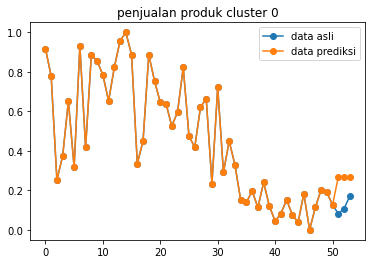

In [43]:
plt.plot(series,marker = 'o',label='data asli')
plt.plot(hasil,marker = 'o',label='data prediksi')
plt.title('penjualan produk cluster 0')
plt.legend()
plt.plot()

In [44]:
model.save('cluster0_newdata.h5')